In [1]:
import re
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

## Helpers

In [2]:
def get_pattern_elem(text, pattern='[0-9][0-9]:[0-9][0-9]', alternative_pattern='[0-9][0-9]\.[0-9][0-9]'):
    """get element from regex pattern. used to get time information from text
    -INPUT:
        -text: str of text where to search pattern
        -pattern: str of regex oattern
        -alternative_pattern: str of alternative regex pattern if first pattern didn't return response
    -OUTPUT:
        - str of matched pattern where . is replaced with :"""
    match=re.search(pattern,text)
    if match is None:
        match=re.search(alternative_pattern,text) 
        if match is None:
            return
    span=match.span()
    return text[span[0]:span[1]].replace('.',':')

In [3]:
def stenos2df(stenos):
    '''Parse stenos to pandas DataFrame
    NB! this function adds steno link to all of the segments!
    -INPUT:
        -stenos: dict of stenos
    -OUTPUT:
        -pd.DataFrame of stenos'''
    stenos_flat=[]
    for steno_url in stenos.keys():
        data_steno=stenos[steno_url]['talk']
        #[row.update({'link_steno':steno_url}) for row in data_steno]
        stenos_flat.extend(data_steno)
    return pd.DataFrame(stenos_flat)

## Data

In [4]:
with open('data/raw/stenos_from_links.json') as f:
    data=json.load(f)

## Format to df

In [5]:
df=stenos2df(data)
df.shape

(213689, 7)

In [6]:
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text
0,10:00 Istungi rakendamine,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=0,https://stenogrammid.riigikogu.ee/201911191000,PKP-25040,SND-559399,"Auväärt kolleegid, auväärt Riigikogu, tere hom..."
1,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,Täna on meil päevakorras olulise tähtsusega ri...
2,1.\n 10:02 Eesti Keske...,Kersti Sarapuu,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=238,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559401,Lugupeetud istungi juhataja! Head kolleegid ja...
3,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=...,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559402,"Aitäh! Ettekandjatele ütlen niipalju, et selle..."
4,1.\n 10:02 Eesti Keske...,Aivar Sõerd,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=...,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559403,"Aitäh, austatud juhataja! Austatud ettekandja!..."


## Get time

In [7]:
def clean_speaker(text):
    """helper func to clean speaker name
    -INPUT:
        -text: str of speaker name
    -OUTPUT:
        -cleaner text"""
    text=text.replace('\n','').replace('<strong>', '').replace('</strong>', '')
    text= re.sub('\d\d:\d\d','', text)
    text=text.strip()
    text=' '.join(text.split())
    return text

def time_from_speaker(text, return_h=True):
    """get time information from speaker name text
    -INPUT:
        -text: str of speaker name
        -return_h: bool if true returns hour infomration otherwise minutes
    -OUTPUT:
        str of tme information"""
    time=re.findall('\d\d:\d\d',text)
    hour, minutes = time[0].split(':')
    if return_h:
        return hour
    return minutes

def has_time(text):
    """check if text contains time information"""
    return bool(re.search('\d\d:\d\d', text))

In [8]:
df['year']=df.link_steno.apply(lambda x: x.split('/')[-1][:4])
df['month']=df.link_steno.apply(lambda x: x.split('/')[-1][4:6])
df['day']=df.link_steno.apply(lambda x: x.split('/')[-1][6:8])
df['time']=df.heading.apply(lambda x: get_pattern_elem(x))
speaker_has_time=df.speaker.apply(has_time)
speaker_times=df.speaker.apply(get_pattern_elem)
df['time']=np.where(speaker_has_time, speaker_times, df.time)
df['seconds_from_start']=df.link_video.apply(lambda x: str(x).split('&t=')[-1])
df['video_link_wo_time']=df.link_video.apply(lambda x: str(x).split('&t=')[0])
df['speaker']=df.speaker.apply(clean_speaker)
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text,year,month,day,time,seconds_from_start,video_link_wo_time
0,10:00 Istungi rakendamine,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=0,https://stenogrammid.riigikogu.ee/201911191000,PKP-25040,SND-559399,"Auväärt kolleegid, auväärt Riigikogu, tere hom...",2019,11,19,10:00,0,https://www.youtube.com/watch?v=GaFL2Zc4OMg
1,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=125,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559400,Täna on meil päevakorras olulise tähtsusega ri...,2019,11,19,10:02,125,https://www.youtube.com/watch?v=GaFL2Zc4OMg
2,1.\n 10:02 Eesti Keske...,Kersti Sarapuu,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=238,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559401,Lugupeetud istungi juhataja! Head kolleegid ja...,2019,11,19,10:02,238,https://www.youtube.com/watch?v=GaFL2Zc4OMg
3,1.\n 10:02 Eesti Keske...,Aseesimees Siim Kallas,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=...,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559402,"Aitäh! Ettekandjatele ütlen niipalju, et selle...",2019,11,19,10:02,1194,https://www.youtube.com/watch?v=GaFL2Zc4OMg
4,1.\n 10:02 Eesti Keske...,Aivar Sõerd,https://www.youtube.com/watch?v=GaFL2Zc4OMg&t=...,https://stenogrammid.riigikogu.ee/201911191000,PKP-25041,SND-559403,"Aitäh, austatud juhataja! Austatud ettekandja!...",2019,11,19,10:02,1231,https://www.youtube.com/watch?v=GaFL2Zc4OMg


In [9]:
df.tail()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text,year,month,day,time,seconds_from_start,video_link_wo_time
213684,6.\n 13:52 Põllumajand...,Põllumajandusminister Helir-Valdor Seeder,None,https://stenogrammid.riigikogu.ee/201011171300,PKP-23999,SND-542721,Aitäh! Ma tahan kõigepealt natuke meenutada se...,2010,11,17,13:52,None,None
213685,6.\n 13:52 Põllumajand...,Aseesimees Jüri Ratas,None,https://stenogrammid.riigikogu.ee/201011171300,PKP-23999,SND-542722,"Teine täpsustav küsimus, Arvo Sarapuu, palun!",2010,11,17,13:52,None,None
213686,6.\n 13:52 Põllumajand...,Arvo Sarapuu,None,https://stenogrammid.riigikogu.ee/201011171300,PKP-23999,SND-542723,"Aitäh, lugupeetud Riigikogu aseesimees! Hea mi...",2010,11,17,13:52,None,None
213687,6.\n 13:52 Põllumajand...,Põllumajandusminister Helir-Valdor Seeder,None,https://stenogrammid.riigikogu.ee/201011171300,PKP-23999,SND-542724,Aitäh! Sellele küsimusele olen ma siit saalist...,2010,11,17,13:52,None,None
213688,6.\n 13:52 Põllumajand...,Aseesimees Jüri Ratas,None,https://stenogrammid.riigikogu.ee/201011171300,PKP-23999,SND-542725,Tänan! Lõpetan selle küsimuse käsitlemise. Hea...,2010,11,17,13:52,None,None


In [10]:
df.shape

(213689, 13)

In [11]:
df.index_pk.nunique()

10261

In [12]:
df.index_snd.nunique()

213689

In [13]:
#any missing time from steno start
df[pd.isnull(df.seconds_from_start)].shape

(0, 13)

In [14]:
#nr of unique stenograms
df.link_steno.nunique()

1493

In [15]:
#nr of unique videos
df.link_video.nunique(), df.video_link_wo_time.nunique()

(72864, 503)

## Quick overview

<AxesSubplot:xlabel='year'>

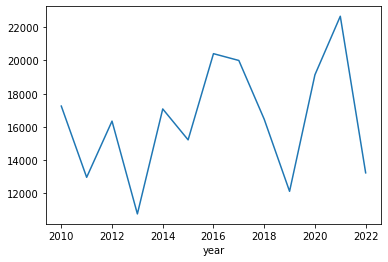

In [16]:
#nr of steno segments per year
df.groupby('year').count()['link_steno'].plot()

<AxesSubplot:xlabel='month'>

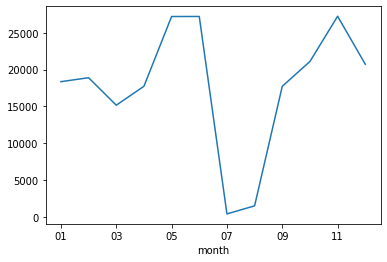

In [18]:
#nr steno segments per month (across all years)
df.groupby('month').count()['link_steno'].plot()

<AxesSubplot:xlabel='day'>

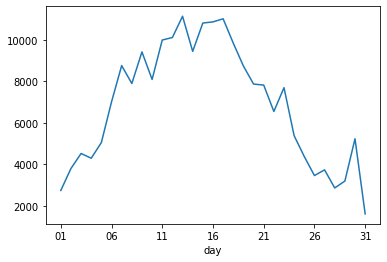

In [19]:
#nr steno segments per day (across years)
df.groupby('day').count()['link_steno'].plot()

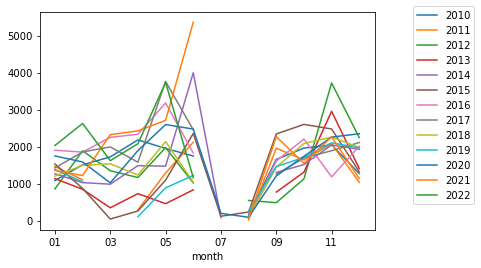

In [18]:
#nr steno segments per month in each year
ax=df.groupby(['month','year']).count()['link_steno'].unstack().plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [19]:
#unique speakers, check if have different capitalization
df.speaker.nunique(), df.speaker.str.lower().nunique()

(738, 738)

<AxesSubplot:>

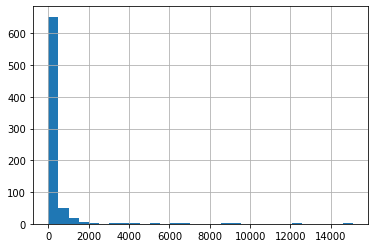

In [24]:
#nr of steno segments per speaker histogram
df.speaker.value_counts().hist(bins=30)

In [25]:
#median and mean steno segments per speaker
df.speaker.value_counts().mean(), df.speaker.value_counts().median()

(289.45997286295795, 48.0)

## Save

In [21]:
df.to_csv('data/interim/stenos.csv',index=False)